In [ ]:
pip install nltk

In [ ]:
pip install nrclex

In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from textblob import TextBlob
from nrclex import NRCLex
from prophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud
import re
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

#downloading necessary NLTK data
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

In [63]:
df = pd.read_csv("fordOnReddit.csv")
df.head(2)

,title,datetime,subreddit,brand
0,Can someone tell me if these car ramps I just ...,2024-07-08 20:16:34,AskMechanics,Ford
1,Borrowed my dad’s Ford w/ 5.4 Triton. He says ...,2024-07-05 22:17:48,AskMechanics,Ford


In [64]:
#creating all functions
#defining a function to retrieve the sentiment for sentiment analysis.
def getSent(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"
#defining a function to delete stopwords.
stopwords = set(stopwords.words('english'))
def delStopwords(text):
    words = text.split()
    wordsFiltered = [word for word in words if word.lower() not in stopwords]
    return " ".join(wordsFiltered)
#defining a function to extract the most frequently used word combinations with tfidf.
def getNgrams(text, ngram_range, label, top_n):
    vect = TfidfVectorizer(ngram_range=ngram_range, stop_words='english')
    tfidf_matrix = vect.fit_transform([text])
    freqs = pd.DataFrame(tfidf_matrix.toarray(), columns=vect.get_feature_names_out()).sum(axis=0)
    freqs = freqs.sort_values(ascending=False).head(top_n)
    return pd.DataFrame({'N-Gram': freqs.index, 'TF-IDF Score': freqs.values, 'Type': label})

In [65]:
#converting 'datetime' column to datetime, creating columns for 'month' and 'year' data and identifying the date range.
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['month'] = df['datetime'].dt.to_period('M')
df['year'] = df['datetime'].dt.year
minDate = df['datetime'].min()
maxDate = df['datetime'].max()
print(f"Dates: {minDate} to {maxDate}")

Dates: 2015-01-12 14:52:38 to 2024-12-07 18:15:58


In [66]:
df['woutStopwords'] = df['title'].apply(delStopwords)

In [67]:
lemm = WordNetLemmatizer()
#removing stopwords and punctuation, converting text to lowercase, tokenizing, lemmatizing, and extracting top emotions
df['woutStopwords'] = df['title'].apply(lambda text: " ".join([word for word in text.split() if word.lower() not in stopwords]))
df['woutStopwords'] = df['woutStopwords'].apply(lambda text: text.lower())
df['woutStopwords'] = df['woutStopwords'].apply(lambda text: re.sub(r'[^\w\s]', '', text))
df['lemmatized'] = df['woutStopwords'].apply(lambda text: [lemm.lemmatize(token) for token in word_tokenize(text)])
df['topEmotions'] = df['woutStopwords'].apply(lambda text: NRCLex(text).top_emotions[0][0] if NRCLex(text).top_emotions else None)
#applying sentiment analysis to the 'woutStopwords' column.
df['sentiment'] = df['woutStopwords'].apply(getSent)
#preprocessing 'lemmatized string'
df['lemmString'] = df['lemmatized'].apply(lambda tokens: " ".join(tokens))
df = df[df['lemmString'].str.strip() != ""]

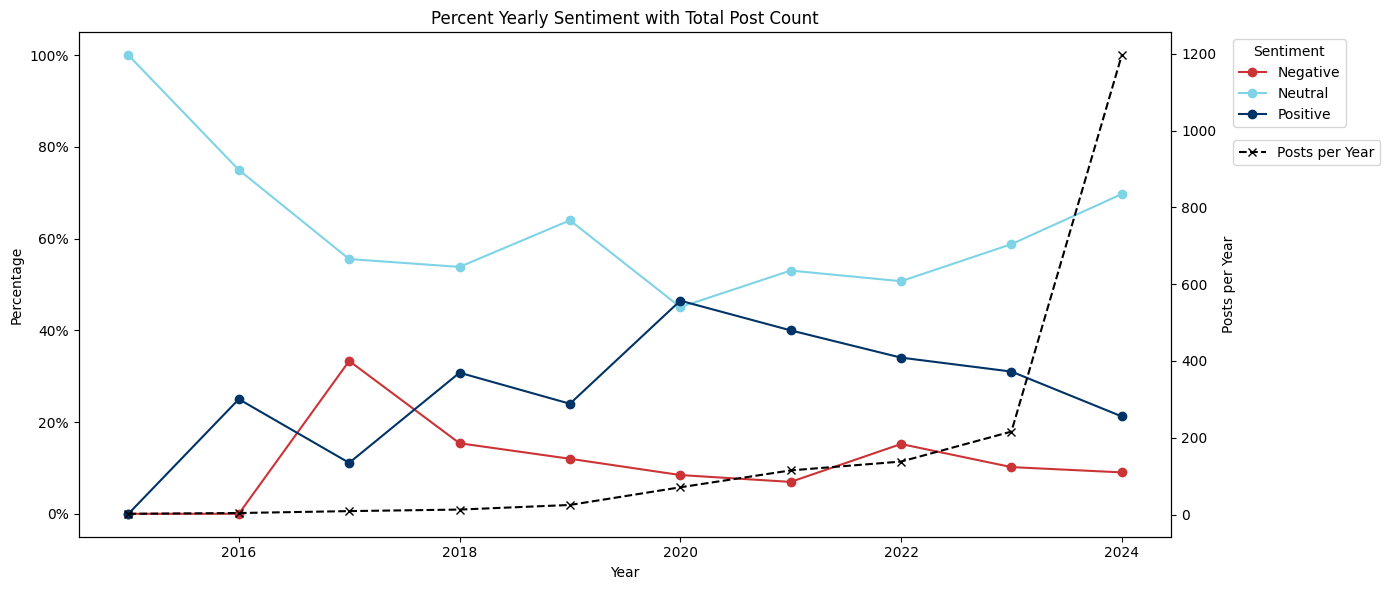

In [68]:
#aggregating yearly post and sentiment percentages.
sentByYear = df.groupby('year')['sentiment'].value_counts(normalize=True).unstack(fill_value=0)
yearlyPostCount = df.groupby('year')['sentiment'].count()
#plotting the line chart, formatting percentages on the first y axis, adding a secondary y axis, relocating the legends for max readability.
fig, ax1 = plt.subplots(figsize=(14, 6))
sentByYear.plot(ax=ax1, marker='o', color=['#CC3336', '#7ED4E6', '#003366'])
ax1.set_xlabel("Year")
ax1.set_ylabel("Percentage")
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x * 100)}%"))
ax1.set_title("Percent Yearly Sentiment with Total Post Count")
ax1.legend(title="Sentiment", loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.5)
ax2 = ax1.twinx()
ax2.plot(yearlyPostCount.index, yearlyPostCount.values, color='black', linestyle='--', marker='x', label='Posts per Year')
ax2.set_ylabel("Posts per Year")
ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 0.8), borderaxespad=0.5)
plt.tight_layout()
plt.show()

In [69]:
#defining custom colors and creating a word cloud visualization.
blues = LinearSegmentedColormap.from_list("blues", ['#003366', '#00509E', '#7ED4E6'], N=256)
reds = LinearSegmentedColormap.from_list("reds", ['#CC3336', '#FF5733', '#FF9999'], N=256)

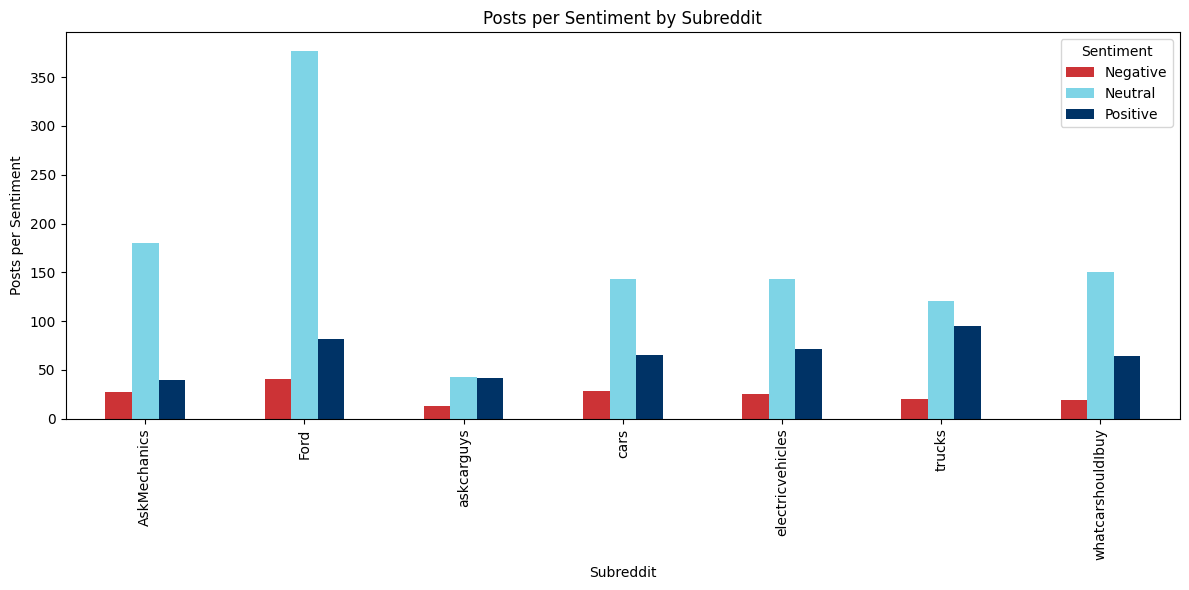

In [70]:
#aggregating sentiment by subreddit.
subredditSentimentCount = df.groupby('subreddit')['sentiment'].value_counts().unstack(fill_value=0)
#defining colors and plotting sentiment by subreddit.
colors = ['#CC3336', '#7ED4E6', '#003366']
subredditSentimentCount.plot(kind='bar', figsize=(12, 6), title="Posts per Sentiment by Subreddit", color=colors)
plt.xlabel("Subreddit")
plt.ylabel("Posts per Sentiment")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

In [71]:
#filtering rows mentioning 'f150' in 'lemmatized_str'
f150LemPosts = df[df['lemmString'].str.contains('f150', case=False, na=False)]

In [72]:
#vectorizing the lemmatized text, fitting with k-means, and printing the top terms per cluster.
tfidfVect = TfidfVectorizer(max_features=5000, stop_words='english')
f150DTM = tfidfVect.fit_transform(f150LemPosts['lemmString'])
clusters = 5
f150KMeans = KMeans(n_clusters=clusters, random_state=42)
f150Labels = f150KMeans.fit_predict(f150DTM)
terms = tfidfVect.get_feature_names_out()
for i in range(clusters):
    clusterWords = f150KMeans.cluster_centers_[i].argsort()[-10:]
    print(f"Cluster {i}: ", [terms[idx] for idx in clusterWords])

Cluster 0:  ['2024', 'tesla', 'ev', 'production', 'price', 'pickup', 'electric', 'f150', 'ford', 'lightning']
Cluster 1:  ['2014', '2018', '1990', '2021', '2015', '1992', 'spotted', 'truck', 'f150', 'ford']
Cluster 2:  ['1990', 'xlt', '46', '54', '50', 'ford', 'f150', '1997', 'triton', 'v8']
Cluster 3:  ['pro', '4x4', 'lightning', 'diesel', 'tailgate', 'transmission', 'issue', 'know', '2023', 'f150']
Cluster 4:  ['beadlocks', 'fueling', 'shut', 'question', 'new', 'ford', 'f150', 'sunroof', '2017', 'raptor']


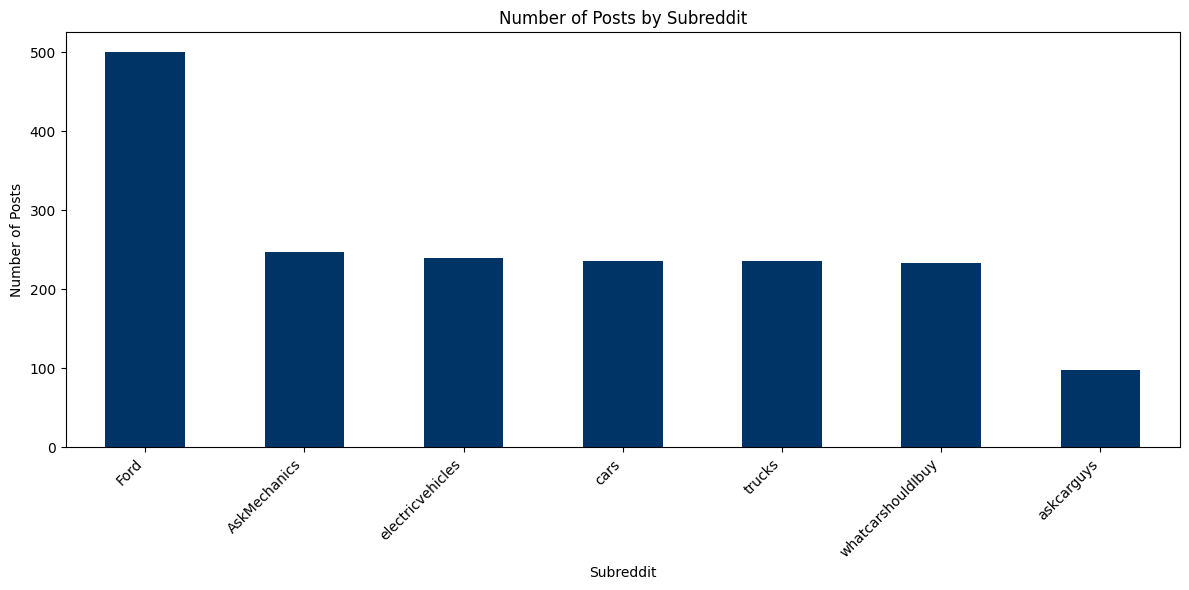

In [73]:
#counting the number of posts per subreddit and plotting the results as a bar chart.
postCountbySubreddit = df['subreddit'].value_counts()
plt.figure(figsize=(12, 6))
postCountbySubreddit.plot(kind='bar', color='#003366', title='Number of Posts by Subreddit') #7ED4E6
plt.xlabel("Subreddit")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [74]:
#filtering posts by trust and fear.
trustEntries = df[df['topEmotions'] == 'trust']
fearEntries = df[df['topEmotions'] == 'fear']

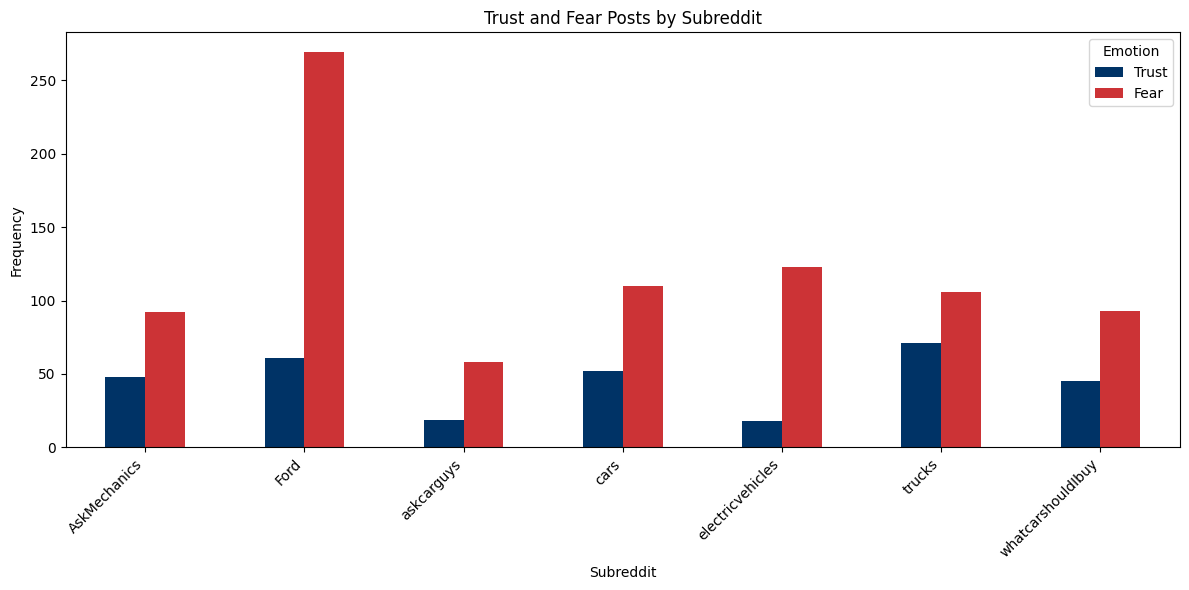

In [75]:
#counting number of trust and fear dominant posts per subreddit and combining into one dataframe for a grouped bar chart visualization.
subredditTrust = trustEntries['subreddit'].value_counts()
subredditFear = fearEntries['subreddit'].value_counts()
trustAndFear = pd.DataFrame({'Trust': subredditTrust, 'Fear': subredditFear})
trustAndFear.plot(kind='bar', figsize=(12, 6), color=['#003366', '#CC3336'])
plt.title("Trust and Fear Posts by Subreddit")
plt.xlabel("Subreddit")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

In [76]:
#analyzing trust and fear texts and extracting keywords.
trustWords = " ".join(trustEntries['woutStopwords'])
fearWords = " ".join(fearEntries['woutStopwords'])
emoVect = CountVectorizer(stop_words='english', max_features=20)

In [77]:
#extracting posts based on model and emotion.
f150FearPosts = df[(df['woutStopwords'].str.contains('f150', case=False, na=False)) & (df['topEmotions'] == 'fear')]
f150TrustPosts = df[(df['woutStopwords'].str.contains('f150', case=False, na=False)) & (df['topEmotions'] == 'trust')]
rangerTrustPosts = df[(df['woutStopwords'].str.contains('ranger', case=False, na=False)) & (df['topEmotions'] == 'trust')]

In [78]:
#joining text from trust posts and text from fear posts to create a word cloud.
trustPosts = pd.DataFrame(emoVect.fit_transform([trustWords]).toarray(), columns=emoVect.get_feature_names_out()).sum().sort_values(ascending=False)
fearPosts = pd.DataFrame(emoVect.fit_transform([fearWords]).toarray(), columns=emoVect.get_feature_names_out()).sum().sort_values(ascending=False)
#joining text from f150 trust posts, and joining text from ranger trust posts.
f150FearWords = " ".join(f150FearPosts['woutStopwords'])
f150TrustWords = " ".join(f150TrustPosts['woutStopwords'])
rangerTrustWords = " ".join(rangerTrustPosts['woutStopwords'])

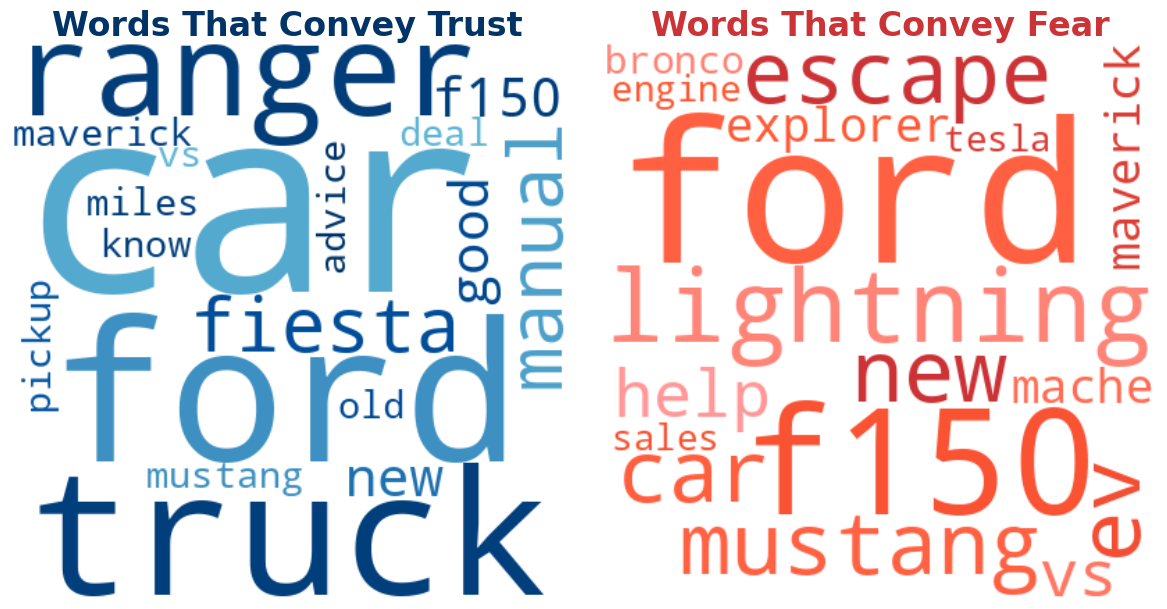

In [79]:
#creating side-by-side word clouds for trust and fear.
trustWC = WordCloud(width=400, height=400, background_color='white', colormap=blues).generate(" ".join(trustPosts.index))
fearWC = WordCloud(width=400, height=400, background_color='white', colormap=reds).generate(" ".join(fearPosts.index))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(trustWC, interpolation='bilinear')
plt.axis('off')
plt.title("Trust Keywords")
plt.title("Words That Convey Trust", fontsize=24, fontweight='bold', color='#003366')
plt.subplot(1, 2, 2)
plt.imshow(fearWC, interpolation='bilinear')
plt.axis('off')
plt.title("Fear Keywords")
plt.title("Words That Convey Fear", fontsize=24, fontweight='bold', color='#CC3336')
plt.tight_layout()
plt.show()

In [80]:
#aggregating sentiment by month and converting to timestamp.
monthlySentiment = df.groupby('month')['sentiment'].value_counts().unstack(fill_value=0)
monthlySentiment.index = monthlySentiment.index.to_timestamp()
#predicting sentiments with Prophet.
pData = monthlySentiment['Positive'].reset_index()
pData.columns = ['ds', 'y']

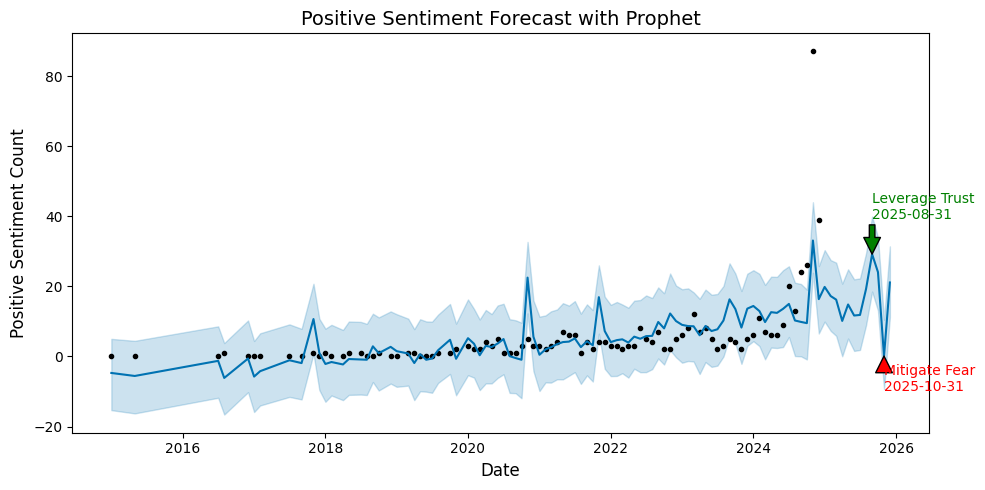

In [84]:
#predicting positive sentiment with Prophet and identifying peaks and valleys in 2025.
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False).fit(pData)
future = model.make_future_dataframe(periods=12, freq='ME')
forecast = model.predict(future)
futureForecast = forecast[forecast['ds'] > '2025-01-01']
peak, valley = futureForecast.loc[futureForecast['yhat'].idxmax()], futureForecast.loc[futureForecast['yhat'].idxmin()]
#annotating peaks and valleys and plotting the visualization.
fig, ax = plt.subplots(figsize=(10, 5))
model.plot(forecast, ax=ax)
plt.title("Positive Sentiment Forecast with Prophet", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Positive Sentiment Count", fontsize=12)
plt.annotate(f"Leverage Trust\n{peak['ds'].date()}", xy=(peak['ds'], peak['yhat']), xytext=(peak['ds'], peak['yhat'] + 10), arrowprops=dict(facecolor='green'), color='green')
plt.annotate(f"Mitigate Fear\n{valley['ds'].date()}", xy=(valley['ds'], valley['yhat']), xytext=(valley['ds'], valley['yhat'] - 10), arrowprops=dict(facecolor='red'), color='red')
plt.grid(False)
plt.tight_layout()
plt.show()

In [83]:
#defining actual and predicted values from the prophet model, calculating MAE and printing the results.
yAct = pData['y']
yPred = forecast.iloc[:len(yAct)]['yhat']
mae = mean_absolute_error(yAct, yPred)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 4.329228785203025
